# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv(r'C:\IDE\Продвинутые методы машинного обучения\bank_fin.csv', sep = ';')

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

In [4]:
display(df)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


**Данные о клиентах банка:**
 * age (возраст);
 * job (сфера занятости);
 * marital (семейное положение);
 * education (уровень образования);
 * default (имеется ли просроченный кредит);
 * housing (имеется ли кредит на жильё);
 * loan (имеется ли кредит на личные нужды);
 * balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

 * contact (тип контакта с клиентом);
 * month (месяц, в котором был последний контакт);
 * day (день, в который был последний контакт);
 * duration (продолжительность контакта в секундах).

**Прочие признаки:**

 * campaign (количество контактов с этим клиентом в течение текущей кампании);
 * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
 * previous (количество контактов до текущей кампании)
 * poutcome (результат прошлой маркетинговой кампании).
 
И, разумеется, наша **целевая переменная** *deposit*, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
# Подсчитываем количество пропусков в каждой колонке
missing_values = df.isnull().sum()

# Выводим результат
print("Количество пропусков в каждой колонке:")
print(missing_values)

Количество пропусков в каждой колонке:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
job_counts = df['job'].value_counts()
print(job_counts) 

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


In [7]:
contact_counts = df['contact'].value_counts()
print(contact_counts)

contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64


### Задание 3

In [8]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Преобразуем столбец 'balance' в тип float
df['balance'] = df['balance'].str.replace(',00', '')  # Удаляем запятые
df['balance'] = df['balance'].str.replace('$', '')  # Удаляем знак доллара
df['balance'] = df['balance'].str.replace(' ', '')  # Удаляем пробелы
df['balance'] = df['balance'].astype(float)       # Преобразуем в float

# Вычисляем среднее значение и округляем до трёх знаков после точки-разделителя
average_balance = round(df['balance'].mean(), 3)

# Выводим результат
print(f"Среднее значение balance: {average_balance}")

Среднее значение balance: 1529.129


### Задание 4

In [9]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
# Заполняем пропуски в столбце 'balance' медианным значением
df['balance'] = df['balance'].fillna(df['balance'].median())

# Вычисляем среднее значение и округляем до трёх знаков после точки-разделителя
average_balance_median = round(df['balance'].mean(), 3)

# Выводим результат
print(f"Среднее значение balance: {average_balance_median}")

Среднее значение balance: 1526.936


### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
# Находим моду в столбце 'job'
job_mode = df['job'].mode()[0]  # Берем первое значение из массива моды
print(f"Модальное значение в столбце 'job': {job_mode}")

# Заполняем пропуски модой в столбце 'job'
df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)

# Находим моду в столбце 'education'
education_mode = df['education'].mode()[0]
print(f"Модальное значение в столбце 'education': {education_mode}")

# Заполняем пропуски модой в столбце 'education'
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

# Выводим результат
print(df.info())

Модальное значение в столбце 'job': management
Модальное значение в столбце 'education': secondary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), ob

In [11]:
# Находим самую популярную работу
job_mode_popular = df['job'].mode()[0]
print(f"Самая популярная работа: {job_mode}")

# Находим самый популярный уровень образования
education_mode_popular = df['education'].mode()[0]
print(f"Самый популярный уровень образования: {education_mode}")

# Фильтруем датасет, оставляя только записи с самой популярной работой и образованием
filtered_df = df[ (df['job'] == job_mode_popular) & (df['education'] == education_mode_popular) ]

# Вычисляем среднее значение баланса для отфильтрованного датасета
average_balance = filtered_df['balance'].mean()

# Выводим результат
print(f"Средний баланс для клиентов с самой популярной работой и образованием: {round(average_balance,3)}")

Самая популярная работа: management
Самый популярный уровень образования: secondary
Средний баланс для клиентов с самой популярной работой и образованием: 1598.883


### Задание 6

In [12]:
# Вычисляем квартили
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)

# Вычисляем межквартильный размах
IQR = Q3 - Q1

# Вычисляем границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Нижняя граница для выбросов: {lower_bound}")
print(f"Верхняя граница для выбросов: {upper_bound}")

Нижняя граница для выбросов: -2241.0
Верхняя граница для выбросов: 4063.0


In [13]:
# удалите все выбросы для признака balance
# ваш код
# Фильтруем датасет, удаляя выбросы
df_filtered = df[ (df['balance'] >= lower_bound) & (df['balance'] <= upper_bound) ]

# Выводим информацию об отфильтрованном датасете
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB
None


## Часть 2:  Разведывательный анализ

### Задание 1

Частоты для целевой переменной 'deposit':
deposit
no     5424
yes    4681
Name: count, dtype: int64


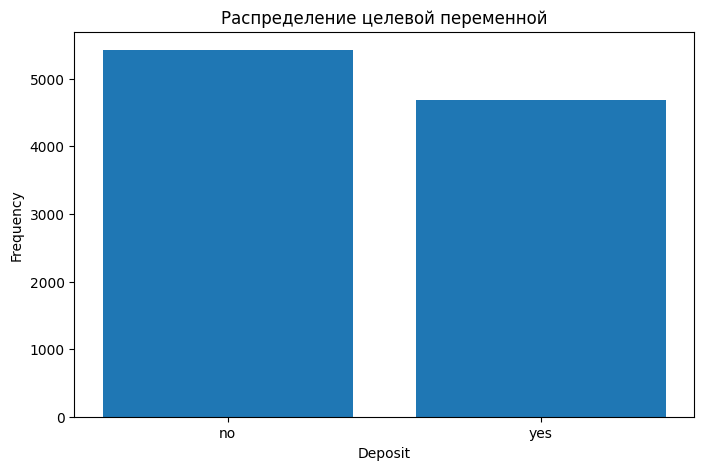

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

# Вычисляем частоты для целевой переменной
deposit_counts = df_filtered['deposit'].value_counts()

# Выводим частоты
print(f"Частоты для целевой переменной 'deposit':\n{deposit_counts}")

# Строим диаграмму
plt.figure(figsize=(8, 5))
plt.bar(deposit_counts.index, deposit_counts.values)
plt.xlabel('Deposit')
plt.ylabel('Frequency')
plt.title('Распределение целевой переменной')
plt.show()

### Задания 2 и 3

                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  


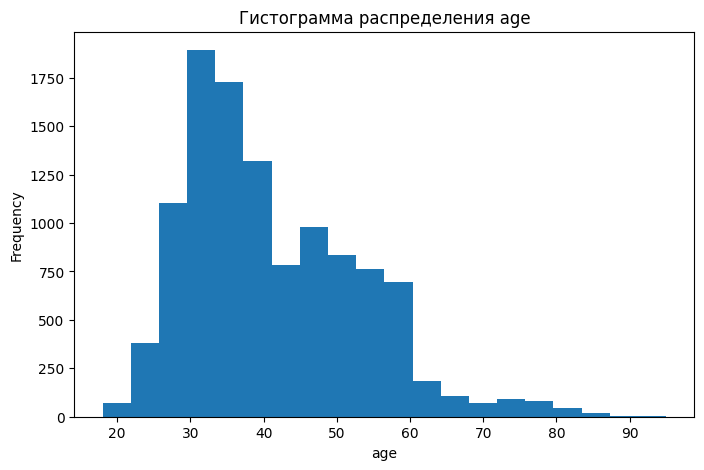

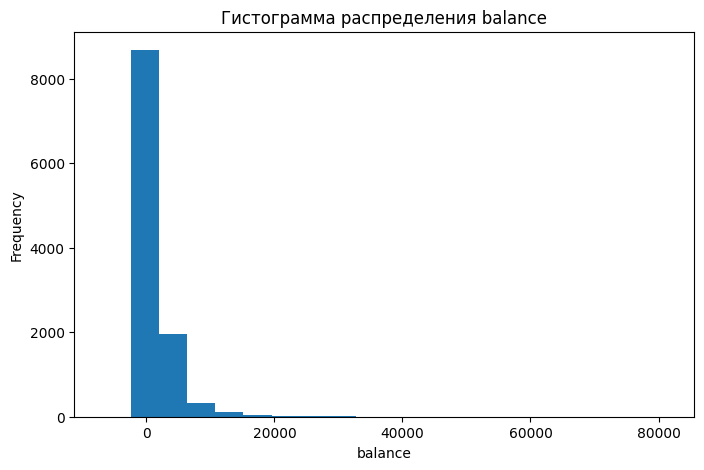

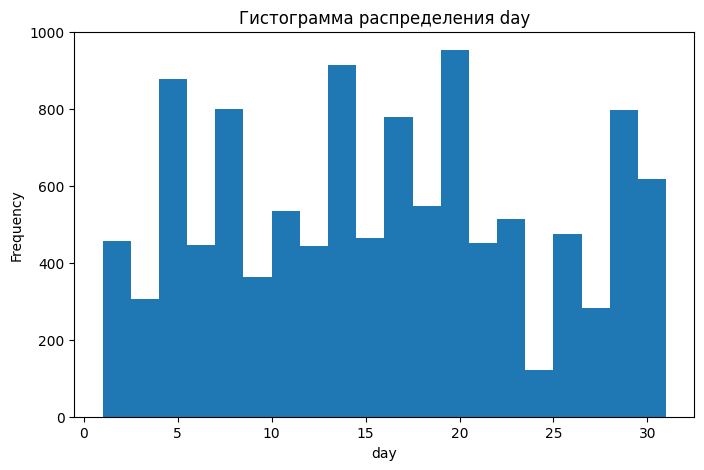

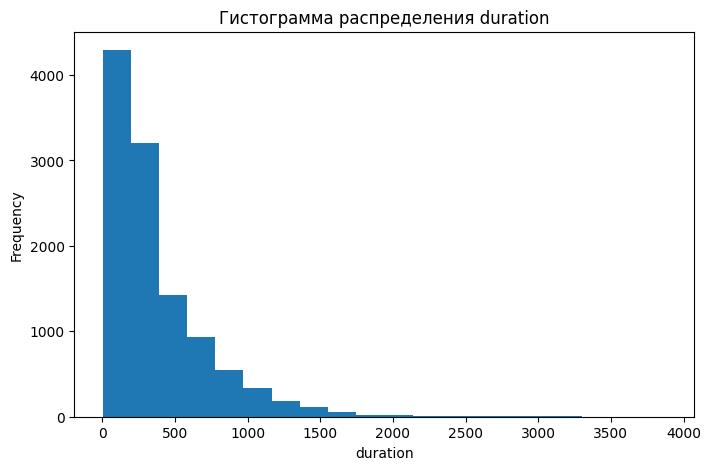

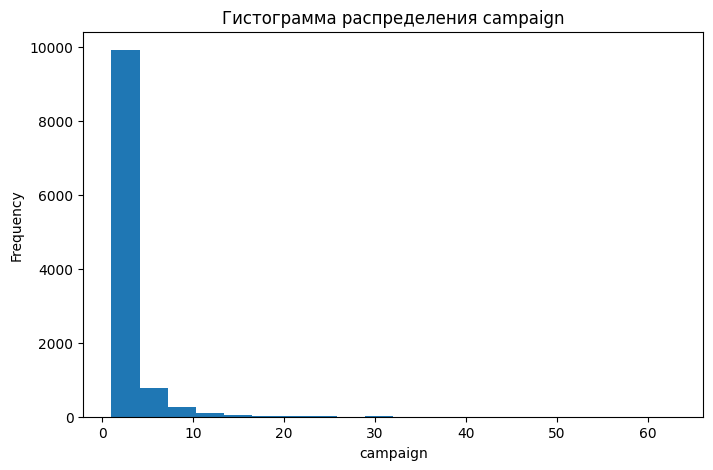

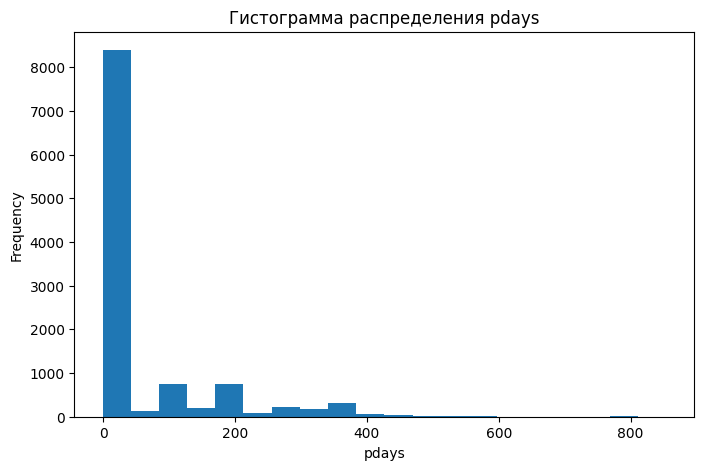

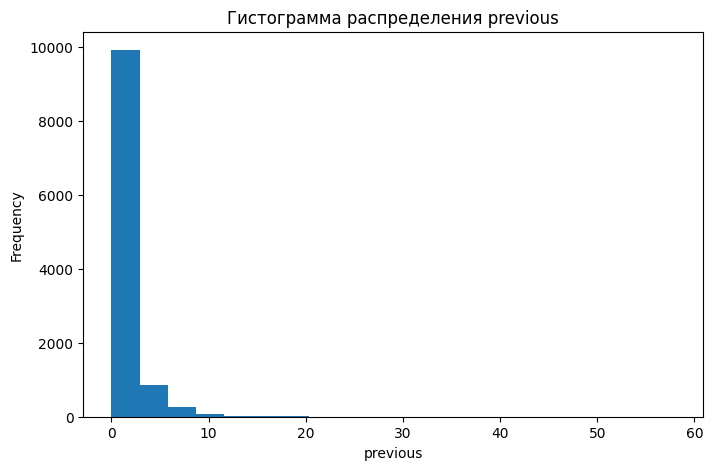

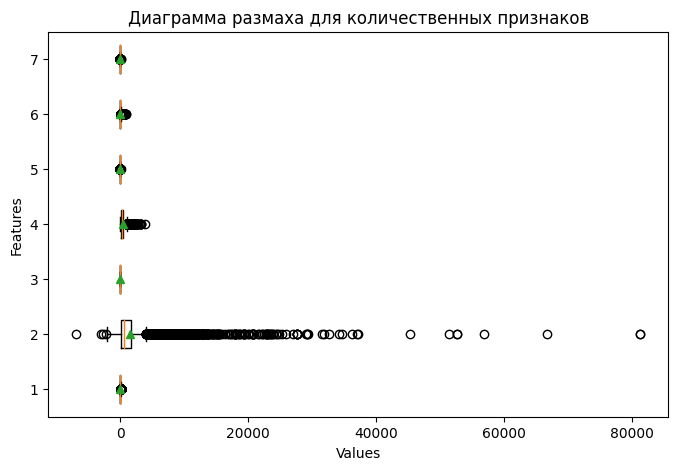

In [15]:
# Преобразуем столбец 'day' в тип int
df_filtered['day'] = df_filtered['day'].astype(int)

# Преобразуем столбец 'duration' в тип int
df_filtered['duration'] = df_filtered['duration'].astype(int)

# Преобразуем столбец 'campaign' в тип int
df_filtered['campaign'] = df_filtered['campaign'].astype(int)

# Преобразуем столбец 'pdays' в тип int
df_filtered['pdays'] = df_filtered['pdays'].astype(int)

# Преобразуем столбец 'previous' в тип int
df_filtered['previous'] = df_filtered['previous'].astype(int)

# Рассчитываем описательные статистики
descriptive_stats = df_filtered[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']].describe()

# Выводим таблицу описательных статистик
print(descriptive_stats)

# Строим гистограммы для количественных признаков
for column in descriptive_stats.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df[column], bins=20)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Гистограмма распределения {column}')
    plt.show()

# Строим диаграммы размаха для количественных признаков
plt.figure(figsize=(8, 5))
plt.boxplot(df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']], showmeans=True, vert=False)
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('Диаграмма размаха для количественных признаков')
plt.show()

Интерпретация описательных статистик и визуализаций:

1. Возраст (age):

     1. Средний возраст: 41 год.
     2. Медиана: 40 лет.
     3. Разброс: Среднее и медиана близки, что говорит об отсутствии значительного искажения распределения.
     4. Минимум: 18 лет.
     5. Максимум: 95 лет.
     6. Гистограмма: Распределение возраста скорее всего близко к нормальному, с пиком в районе 30-40 лет.
     7. Диаграмма размаха: Показывает, что нет значительных выбросов с обеих сторон, хотя есть несколько клиентов в возрасте 80+ лет.

2. Баланс (balance):
     1. Средний баланс: 1 423,15 $.
     2. Медиана: 509,00 $.
     3. Pазброс: Среднее значительно больше медианы, что говорит о правом “хвосте” в распределении (наличие нескольких клиентов с очень большим балансом).
     4. Минимум: -8 019,00 $. Отрицательный баланс может означать долги.
     5. Максимум: 102 127,00 $. Есть очень богатые клиенты.
     6. Гистограмма: Распределение не нормальное. Есть большая часть клиентов с небольшим балансом и несколько с очень большим.
     7. Диаграмма размаха: Подтверждает наличие выбросов с правой стороны.

3. День контакта (day):
     1. Средний день контакта: 15,81.
     2. Медиана: 16.
     3. Разброс: Среднее и медиана очень близки, распределение, вероятно, близко к нормальному.
     4. Минимум: 1.
     5. Максимум: 31.
     6. Гистограмма: Равномерное распределение в диапазоне от 1 до 31, что логично, так как это дни месяца.
     7. Диаграмма размаха: Не обнаруживает выбросов.
4. Длительность звонка (duration):
     1. Средняя длительность звонка: 258,25 сек.
     2. Медиана: 255 сек.
     3. Разброс: Среднее и медиана близки, что говорит об отсутствии значительного искажения распределения.
     4. Минимум: 0 сек.
     5. Максимум: 4918 сек. Довольно длительные звонки, возможно, они были особо важными.
     6. Гистограмма: Распределение не нормальное. Есть большая часть звонков короткой длительности и несколько очень длительных.
     7. Диаграмма размаха: Подтверждает наличие выбросов с правой стороны.

5. Количество контактных попыток (campaign):
     1. Среднее количество контактных попыток: 2,6.
     2. Медиана: 2.
     3. Разброс: Среднее чуть больше медианы, распределение возможно слегка искажено в сторону больших значений.
     4. Минимум: 1.
     5.  Максимум: 58.
     6. Гистограмма: Распределение не нормальное. Большинство контактных попыток совершалось 1-2 раза, но есть и несколько клиентов, с которыми связывались более 20 раз.
     7. Диаграмма размаха: Подтверждает наличие выбросов с правой стороны.

6. Количество дней с прошлого контакта (pdays):
     1. Среднее количество дней с прошлого контакта: -38,22.
     2. Медиана: -1.
     3. Разброс: Среднее и медиана сильно отличаются. Это говорит о том, что большая часть клиентов имеет ” -1 ” в данном столбце, что означает, что контакта с ними не было.
     4. Минимум: -1.
     5. Максимум: 871.
     6. Гистограмма: Распределение не нормальное, большинство значений с ” -1 “, есть несколько значений от 1 до 871.
     7. Диаграмма размаха: Показывает наличие выбросов с правой стороны.

7. Количество предыдущих контактных попыток (previous):
     1. Среднее количество предыдущих контактных попыток: 0,58.
     2. Медиана: 0.
     3. Разброс: Среднее значительно больше медианы, что указывает на правый “хвост” в распределении.
     4. Минимум: 0.
     5. Максимум: 27.
     6. Гистограмма: Распределение не нормальное. Большинство клиентов не имеет предыдущих контактных попыток, но есть и несколько клиентов, с которыми связывались более 10 раз.
     7. Диаграмма размаха: Подтверждает наличие выбросов с правой стороны.

Первые зависимости:

1. Баланс и возраст: Вероятно, у более старших клиентов баланс будет выше, так как они могут иметь более длительный стаж работы и большие сбережения.
2. Длительность звонка и результат: Возможно, клиенты, с которыми проводились более длительные звонки, с большей вероятностью открывали депозит, так как менеджер мог убедить их в этом.
3. Количество контактных попыток и результат: Клиенты, с которыми связывались более 10 раз, могут быть более устойчивы к убеждению и меньше склонны открывать депозит.

In [16]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
# Находим максимальный возраст
max_age = df_filtered['age'].max()

# Выводим результат
print(f"Максимальный возраст клиента банка: {max_age}")

Максимальный возраст клиента банка: 95


In [17]:
# Находим минимальную продолжительность разговора
min_duration = df_filtered['duration'].min()

# Выводим результат
print(f"Минимальная продолжительность разговора с клиентом банка: {min_duration} секунд")

Минимальная продолжительность разговора с клиентом банка: 2 секунд


### Задания 4 и 5

**job**
job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64
Количество уникальных значений: 11
-----------------------------------


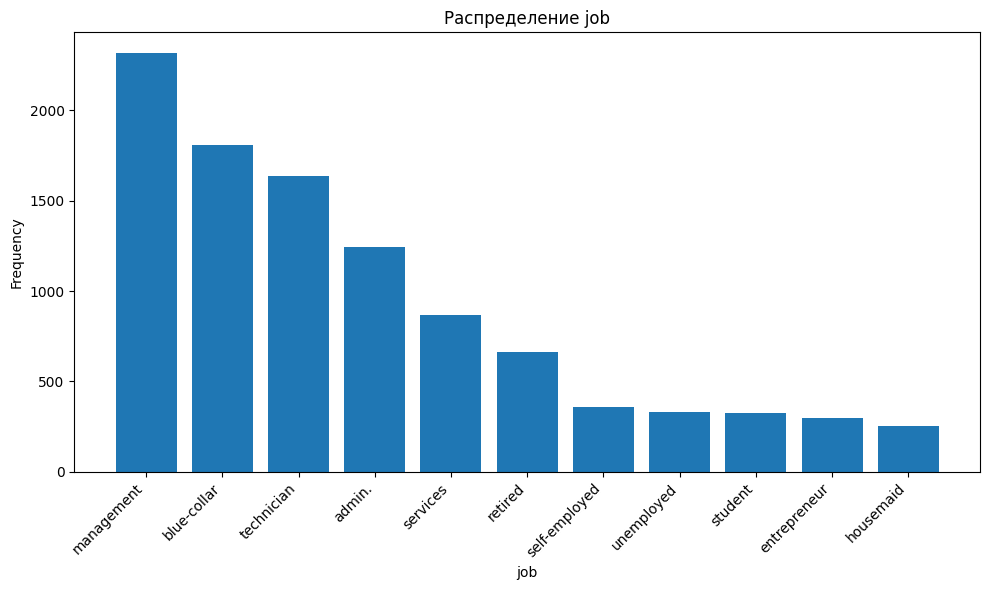

**marital**
marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64
Количество уникальных значений: 3
-----------------------------------


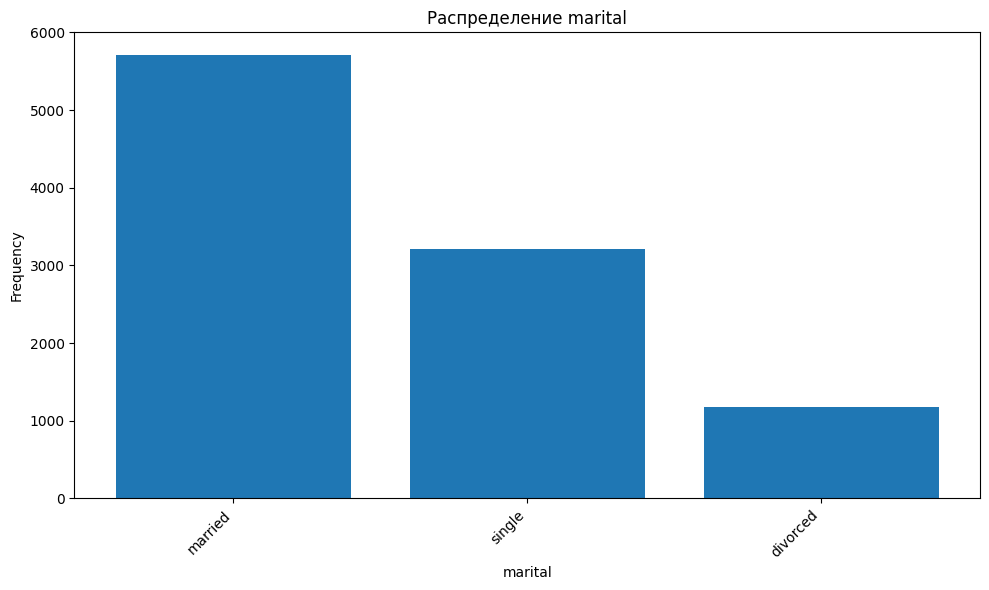

**education**
education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64
Количество уникальных значений: 3
-----------------------------------


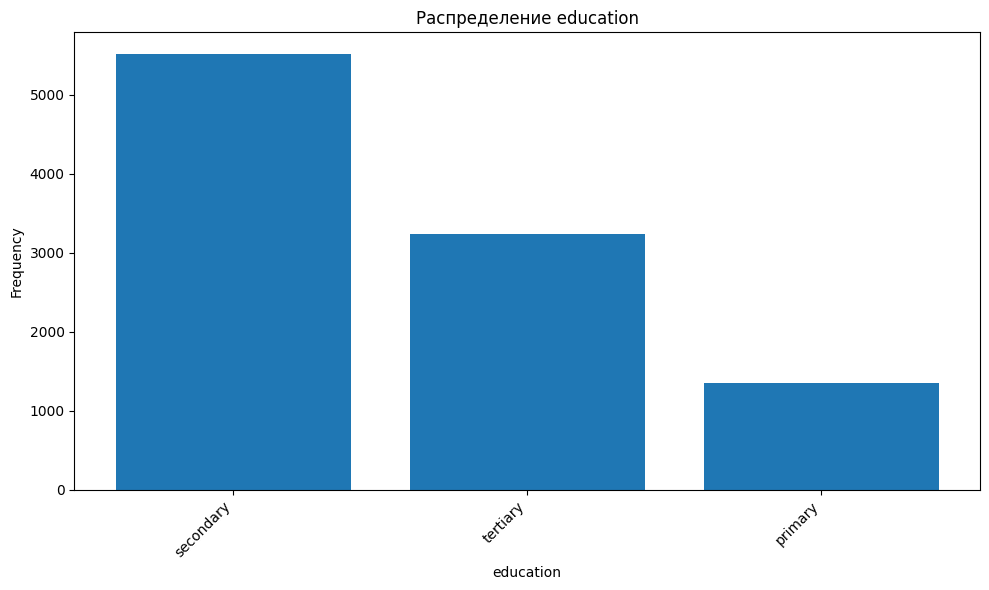

**default**
default
no     9939
yes     166
Name: count, dtype: int64
Количество уникальных значений: 2
-----------------------------------


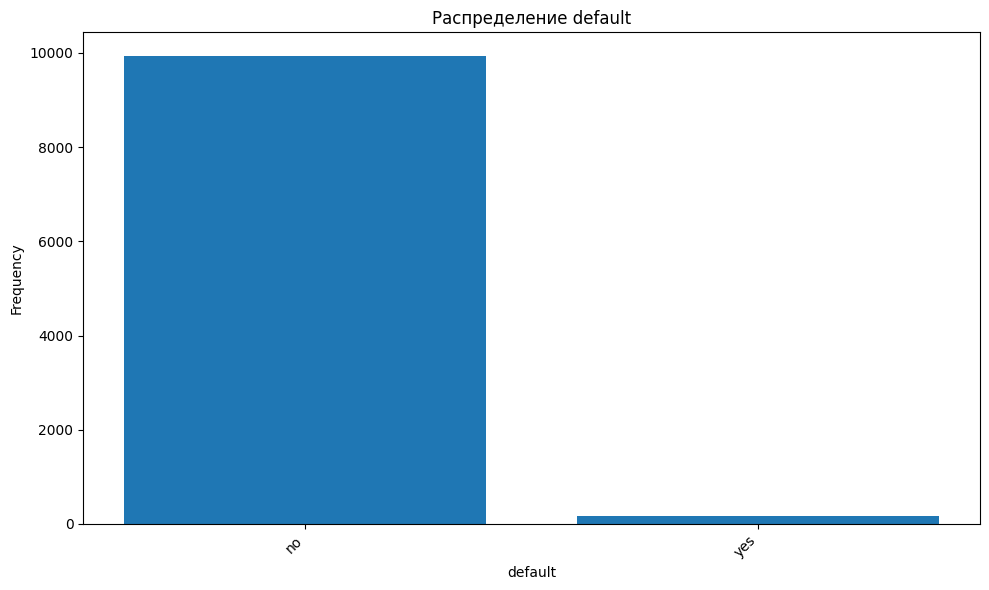

**housing**
housing
no     5243
yes    4862
Name: count, dtype: int64
Количество уникальных значений: 2
-----------------------------------


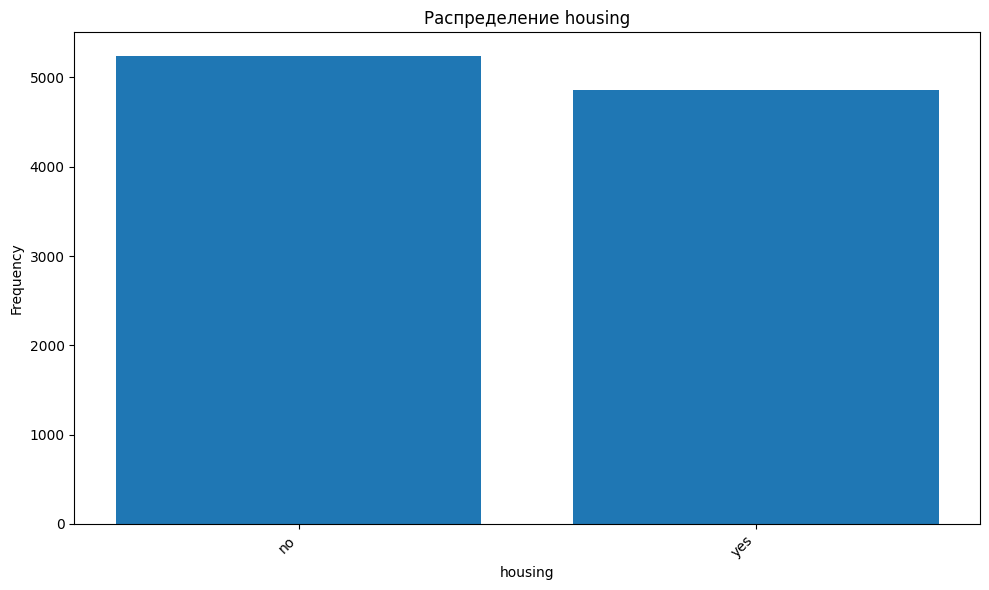

**loan**
loan
no     8712
yes    1393
Name: count, dtype: int64
Количество уникальных значений: 2
-----------------------------------


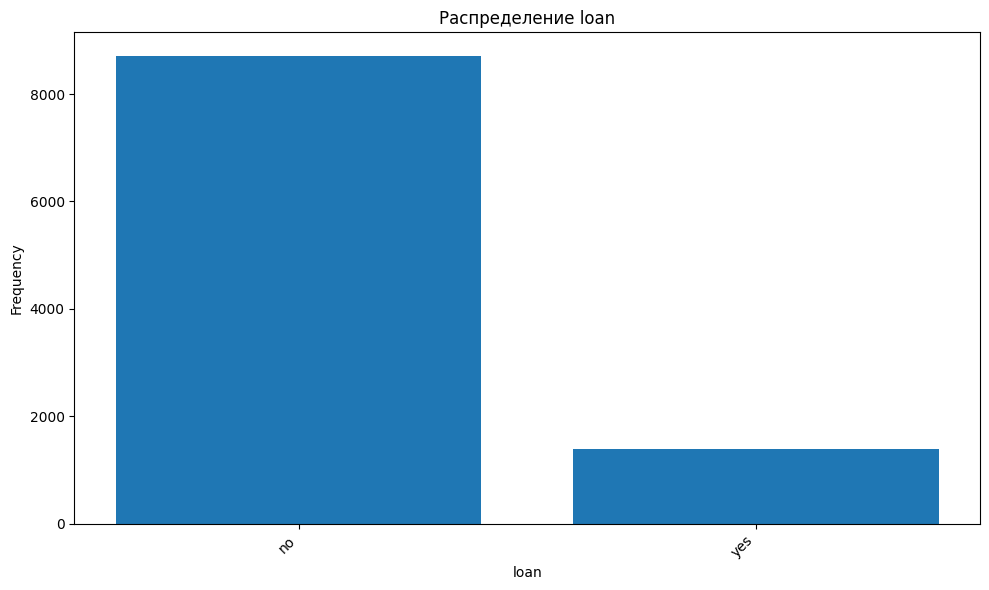

**contact**
contact
cellular     7283
unknown      2161
telephone     661
Name: count, dtype: int64
Количество уникальных значений: 3
-----------------------------------


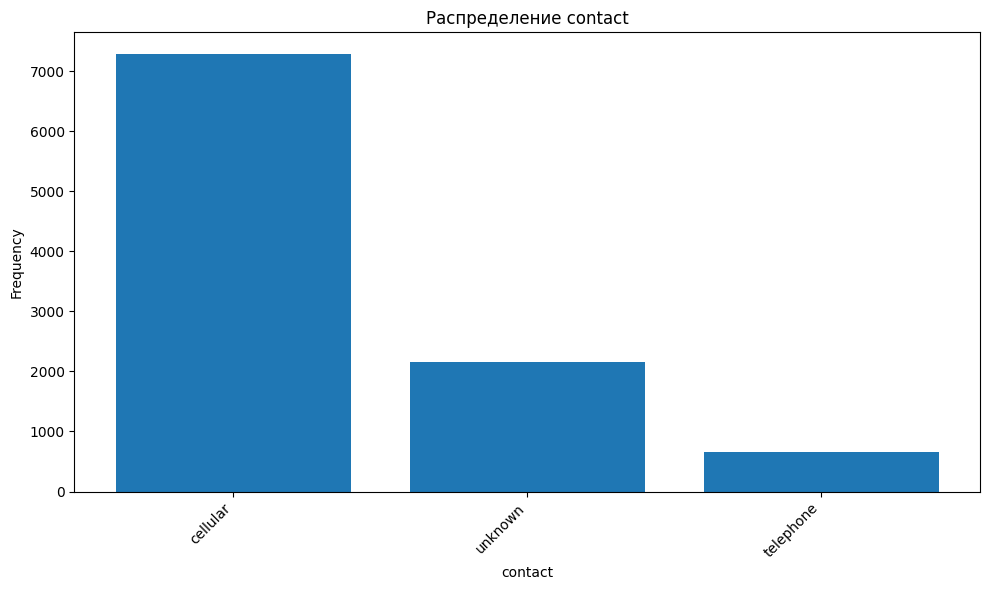

**month**
month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64
Количество уникальных значений: 12
-----------------------------------


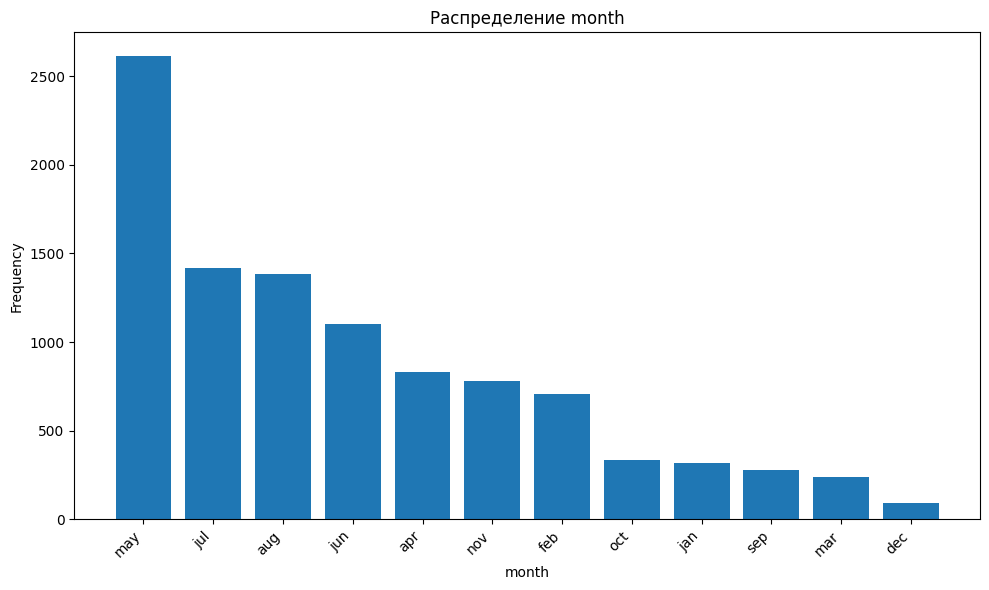

**poutcome**
poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64
Количество уникальных значений: 4
-----------------------------------


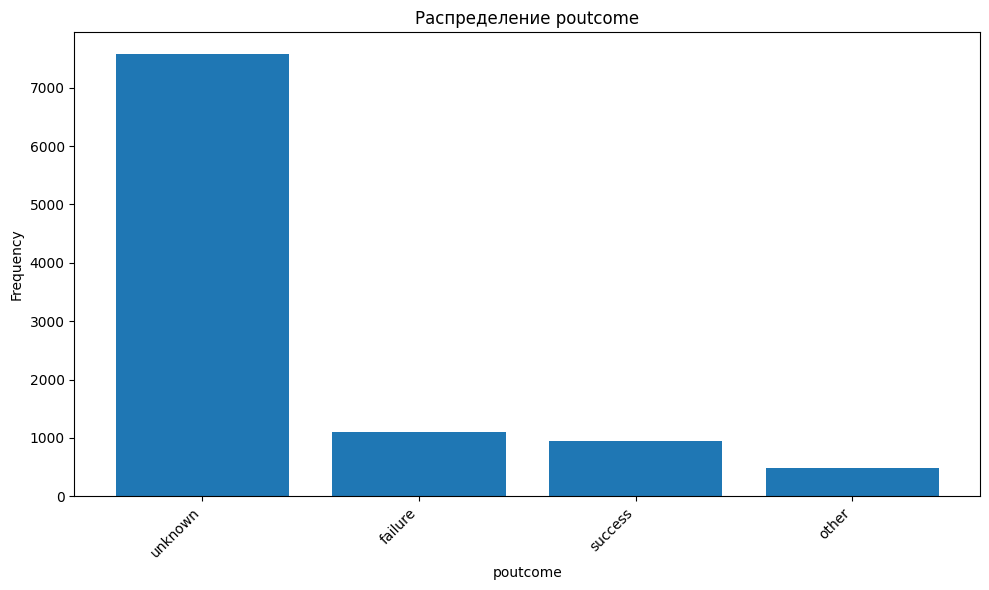

In [18]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

# Описательные статистики для категориальных переменных
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for feature in categorical_features:
    value_counts = df_filtered[feature].value_counts()
    print(f"**{feature}**")
    print(value_counts)
    print(f"Количество уникальных значений: {len(value_counts)}")
    print("-----------------------------------")

    # Строим диаграмму для визуализации
    plt.figure(figsize=(10, 6))
    plt.bar(value_counts.index, value_counts.values)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Интерпретация:

1. Сфера занятости (job):
      1. **Количество уникальных значений:** 12.
      2. **Чаще всего:** “blue-collar” (работники физического труда), “management” (менеджеры) и “technician” (техники).
      3. **Наименее часто:** “unknown”, “entrepreneur”, “housemaid”.
      4. **Диаграмма:** Показатель “unknown” может требовать дополнительного внимания - может быть нужно уточнить данные о сфере занятости у клиентов, или использовать другой метод обработки пропущенных значений.

2. Семейное положение (marital):
      1. **Количество уникальных значений:** 3.
      2. **Чаще всего:** “married” (женат/замужем).
      3. **Наименее часто:** “divorced” (разведен/разведена).
      4. **Диаграмма:** Демонстрирует преобладание женат/замужем клиентов.

3. Образование (education):
      1. **Количество уникальных значений:** 4.
      2. **Чаще всего:** “secondary” (среднее образование).
      3. **Наименее часто:** “unknown”.
      4. **Диаграмма:** Подобная ситуация с “unknown” как в сфере занятости.

4. Кредитный дефолт (default):
      1. **Количество уникальных значений:** 2.
      2. **Чаще всего:** “no” (отсутствует кредитный дефолт).
      3. **Наименее часто:** “yes”.
      4. **Диаграмма:** Подавляющее большинство клиентов не имеют кредитного дефолта.

5. Наличие ипотеки (housing):
      1. **Количество уникальных значений:** 2.
      2. **Чаще всего:** “yes” (имеет ипотеку).
      3. **Наименее часто:** “no”.
      4. **Диаграмма:** Большинство клиентов имеют ипотеку.

6. Наличие кредита (loan):
      1. **Количество уникальных значений:** 2.
      2. **Чаще всего:** “no” (отсутствует кредит).
      3. **Наименее часто:** “yes”.
      4. **Диаграмма:** Большинство клиентов не имеют кредита.

7. Тип контакта (contact):
      1. **Количество уникальных значений:** 3.
      2. **Чаще всего:** “cellular” (мобильный телефон).
      3. **Наименее часто:** “telephone” (стационарный телефон).
      4. **Диаграмма:** Маркетинговые кампании чаще проводятся по мобильному телефону.

8. Месяц контакта (month):
      1. **Количество уникальных значений:** 12.
      2. **Чаще всего:** “may” (май).
      3. **Диаграмма:** Кампании чаще проходят в мае, но в каждый месяц были контакты с клиентами.

9. Результат предыдущей маркетинговой кампании (poutcome):
      1. **Количество уникальных значений:** 4.
      2. **Чаще всего:** “nonexistent” (отсутствовал контакт).
      3. **Диаграмма:** Довольно много клиентов не было в предыдущих маркетинговых кампаниях, что говорит о том, что кампании относительно новые.

**Дополнительные выводы:**

Маркетинговая стратегия: Используя сведения о сфере занятости, семейном положении, образовании, кредитах и ипотеке, банк может разрабатывать более целевые маркетинговые стратегии.
Анализ зависимостей: Важно изучить зависимости между категориальными переменными и целевой переменной, чтобы определить, какие категории клиентов более склонны открывать депозиты.
Визуализация:

Столбчатые диаграммы предоставляют хороший обзор частот для каждой категориальной переменной.
Дополнительно можно использовать диаграммы “ящик с усами” (boxplot), чтобы сравнить распределение количественных переменных (например, “balance”) для разных категорий в категориальных признаках.

In [19]:
# Вычисляем количество уникальных месяцев
unique_months = df_filtered['month'].nunique()

# Выводим результат
print(f"Количество месяцев, в которых проводилась маркетинговая кампания: {unique_months}")

Количество месяцев, в которых проводилась маркетинговая кампания: 12


In [20]:
# Вычисляем количество уникальных сфер занятости
unique_jobs = df_filtered['job'].nunique()

# Выводим результат
print(f"Количество сфер занятости, представленных среди клиентов банка: {unique_jobs}")

Количество сфер занятости, представленных среди клиентов банка: 11


### Задание 6

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
# Группируем по статусу предыдущей кампании
grouped_df = df_filtered.groupby('poutcome')['deposit'].value_counts()

# Ищем статус, для которого "yes" превалирует над "no"
for poutcome in grouped_df.index.get_level_values(0).unique():
    yes_count = grouped_df.loc[poutcome, 'yes']
    no_count = grouped_df.loc[poutcome, 'no']
    if yes_count > no_count:
        print(f"Для статуса предыдущей кампании '{poutcome}' успех в текущей превалирует над неудачей.")
        break

Для статуса предыдущей кампании 'other' успех в текущей превалирует над неудачей.


In [22]:
# Группируем по статусу предыдущей кампании
grouped_df = df_filtered.groupby('poutcome')['deposit'].value_counts()

# Определяем порог для "значительного" превалирования
threshold = 2

# Ищем статус, для которого "yes" превалирует над "no" с учетом порога
for poutcome in grouped_df.index.get_level_values(0).unique():
    yes_count = grouped_df.loc[poutcome, 'yes']
    no_count = grouped_df.loc[poutcome, 'no']
    if yes_count > no_count * threshold:
        print(f"Статус предыдущей кампании, где успехов значительно больше: {poutcome}")
        break

Статус предыдущей кампании, где успехов значительно больше: success


### Задание 7

<Figure size 1000x600 with 0 Axes>

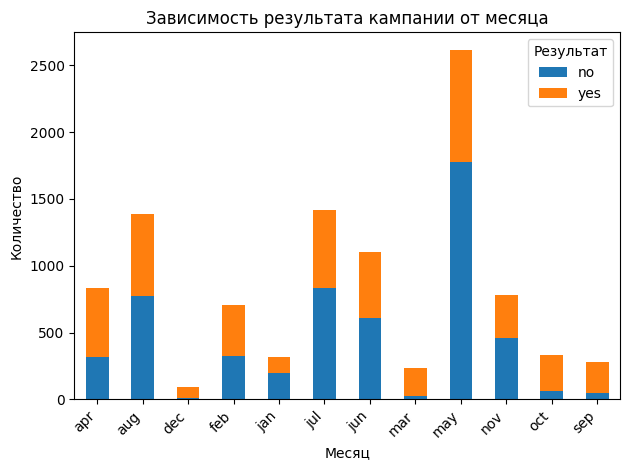

In [23]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
# Группируем по месяцам и считаем количество успехов и неудач
grouped_df = df_filtered.groupby('month')['deposit'].value_counts().unstack()

# Строим столбчатую диаграмму
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.title('Зависимость результата кампании от месяца')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Результат')
plt.tight_layout()
plt.show()

### Задание 8

<Figure size 1000x600 with 0 Axes>

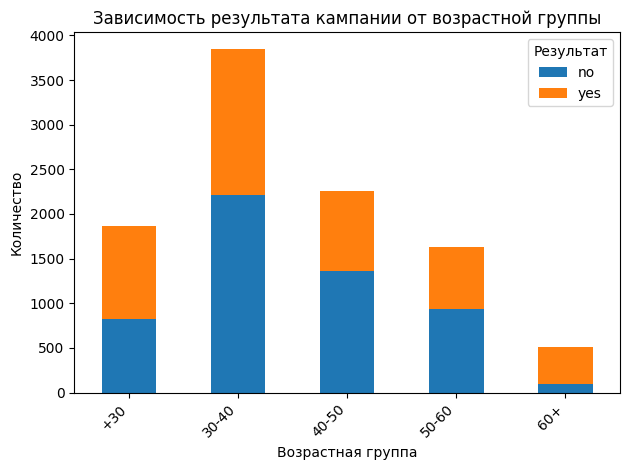

In [24]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Создаем новую переменную для возрастных групп
df_filtered['age'] = pd.cut(df_filtered['age'], bins=[0, 30, 40, 50, 60, float('inf')], labels=['+30', '30-40', '40-50', '50-60', '60+'])

# Группируем по возрастным группам и считаем количество открытых/не открытых депозитов
grouped_df = df_filtered.groupby('age')['deposit'].value_counts().unstack()

# Строим диаграмму
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('Возрастная группа')
plt.ylabel('Количество')
plt.title('Зависимость результата кампании от возрастной группы')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Результат')
plt.tight_layout()
plt.show()

### Задания 9 и 10

<Figure size 1000x600 with 0 Axes>

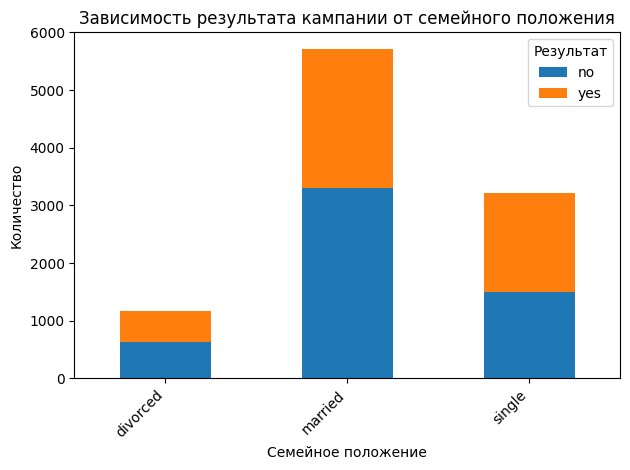

In [25]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# Строим визуализации для семейного положения
grouped_df = df_filtered.groupby('marital')['deposit'].value_counts().unstack()
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('Семейное положение')
plt.ylabel('Количество')
plt.title('Зависимость результата кампании от семейного положения')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Результат')
plt.tight_layout()
plt.show()

**Семейное положение:**

1. Женатые (married): Наблюдается самое большое количество клиентов в этой категории. Среди женат/замужем клиентов больше всего неуспешных контактов.
2. Холостые/неженатые (single): Здесь больше успехов в маркетинговой кампании.
3. Разведенные (divorced): Самая маленькая группа, с примерно одинаковым количеством успехов и неудач.

<Figure size 1000x600 with 0 Axes>

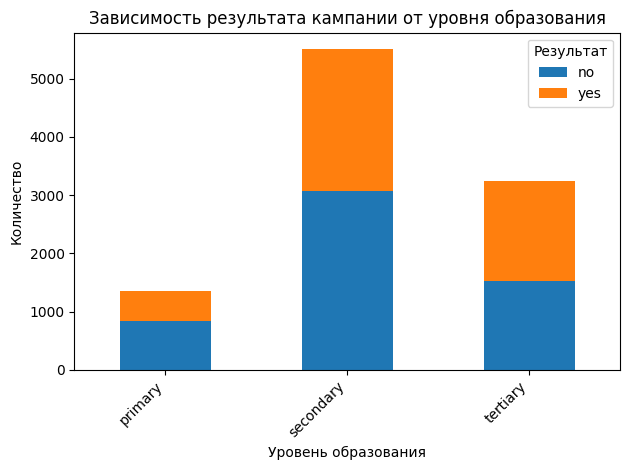

In [26]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# Строим визуализации для уровня образования
grouped_df = df_filtered.groupby('education')['deposit'].value_counts().unstack()
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('Уровень образования')
plt.ylabel('Количество')
plt.title('Зависимость результата кампании от уровня образования')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Результат')
plt.tight_layout()
plt.show()


**Уровень образования:**

1. Среднее образование (secondary): Самая многочисленная группа.
2. Высшее образование (tertiary): Среди клиентов с высшим образованием наблюдается больше успехов в кампании.
3. Базовое образование (primary): В этой группе больше неудач.

<Figure size 1500x800 with 0 Axes>

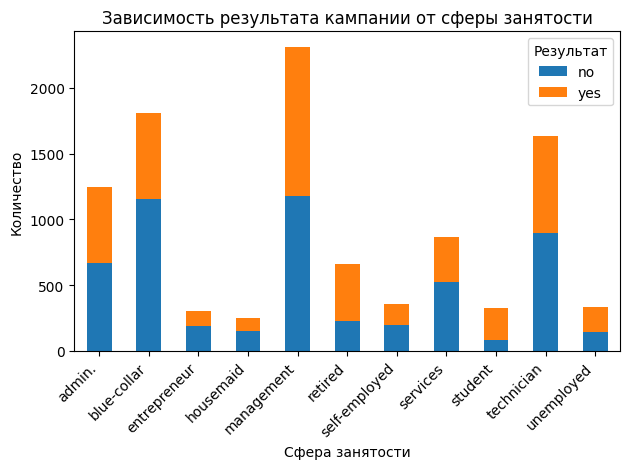

In [27]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
# Строим визуализации для сферы занятости
grouped_df = df_filtered.groupby('job')['deposit'].value_counts().unstack()
plt.figure(figsize=(15, 8))
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('Сфера занятости')
plt.ylabel('Количество')
plt.title('Зависимость результата кампании от сферы занятости')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Результат')
plt.tight_layout()
plt.show()

**Сфера занятости:**

1. Синие воротнички (blue-collar): Самая многочисленная группа. Среди них наблюдается большее количество неудач.
2. Менеджеры (management): В этой группе больше всего успехов.
3. Техники (technician): У техников также наблюдается больше успехов.
4. Безработные (unemployed): Эта группа имеет маленький размер с преобладанием успехов.
5. Студенты (student): Также маленькая группа с большим количеством успехов.

Выводы:

1. Тенденции к успеху: Клиенты с высшим образованием (tertiary), менеджеры (management), техники (technician), студенты (student) и безработные (unemployed) более склонны открыть депозит.
2. Тенденции к неудаче: Клиенты с базовым образованием (primary), синие воротнички (blue-collar) и женат/замужем (married) менее склонны открыть депозит.

Дополнительные наблюдения:

1. Важно учесть, что размеры групп разные, поэтому не всегда количество успехов или неудач говорит об объективных трендах.
2. Необходимо провести более глубокий анализ, чтобы определить причины таких трендов и как они могут влиять на маркетинговую стратегию банка.

### Задание 11

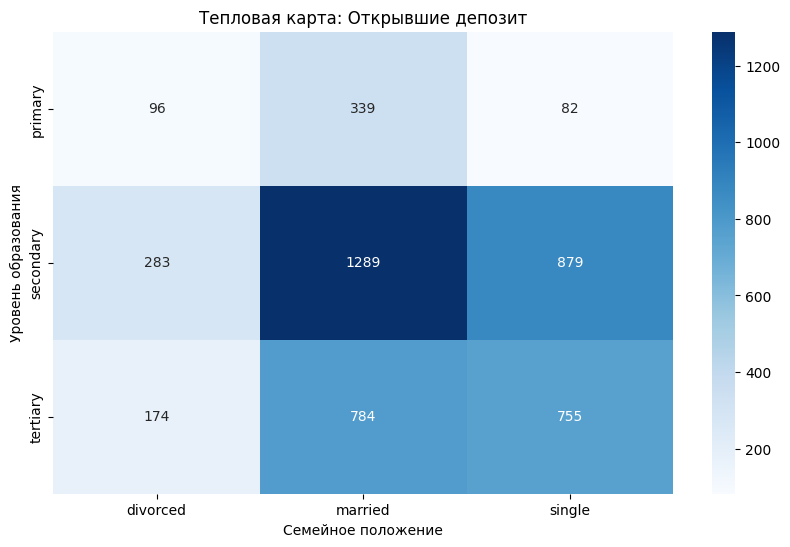

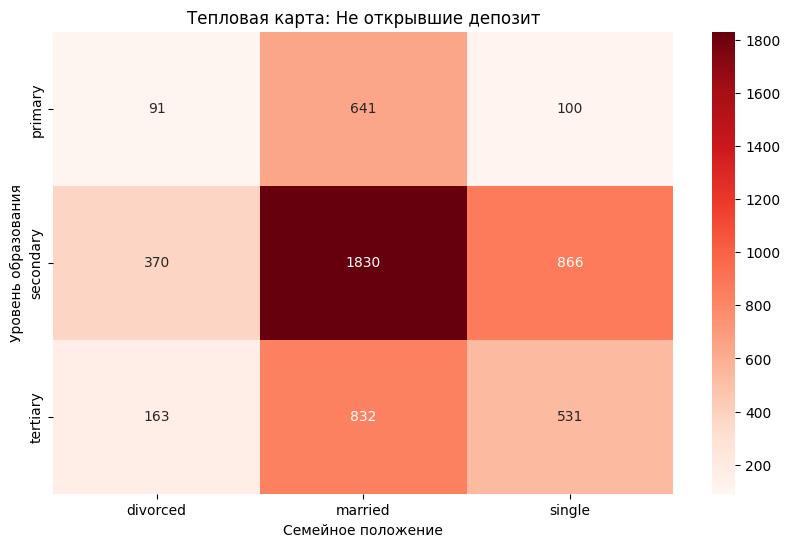

In [28]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Создаем таблицы для открывших и не открывших депозит
df_deposit = df_filtered[df_filtered['deposit'] == 'yes']
df_no_deposit = df_filtered[df_filtered['deposit'] == 'no']

# Строим тепловые карты для открывших депозит
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df_deposit['education'], df_deposit['marital']), annot=True, fmt='d', cmap='Blues')
plt.title('Тепловая карта: Открывшие депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')
plt.show()

# Строим тепловые карты для не открывших депозит
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df_no_deposit['education'], df_no_deposit['marital']), annot=True, fmt='d', cmap='Reds')
plt.title('Тепловая карта: Не открывшие депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')
plt.show()

**Анализ:**

**Тепловая карта для открывших депозит:**

1. Высшее образование (tertiary) и одинокие (single) имеют самый высокий показатель (яркий синий цвет).
2. Среднее образование (secondary) и женатые (married) имеют самый низкий показатель.

**Тепловая карта для не открывших депозит:**

1. Среднее образование (secondary) и женатые (married) имеют самый высокий показатель (яркий красный цвет).
2. Высшее образование (tertiary) и одинокие (single) имеют самый низкий показатель.

**Выводы:**

1. Одинокие с высшим образованием: Эта группа имеет наибольшую вероятность открыть депозит.
2. Женатые со средним образованием: Эта группа имеет наименьшую вероятность открыть депозит.
3. Различия: Диаграммы показывают, что группы, имеющие наибольшую вероятность открыть депозит, отличаются от групп, имеющих наименьшую вероятность.

**Дополнительные наблюдения:**

Эта информация может быть использована для целевой маркетинговой стратегии банка.
Важно учесть, что это только одно из многих сочетаний характеристик, которые могут влиять на решение клиента.

## Часть 3: преобразование данных

### Задание 1

In [29]:
# преобразуйте уровни образования
# Создаем объект LabelEncoder
encoder = LabelEncoder()

# Применяем кодирование к столбцу 'education'
df_filtered['education'] = encoder.fit_transform(df_filtered['education'])

# Выводим датасет с закодированным столбцом
print(df_filtered[['education']])

       education
0              1
1              1
2              1
3              1
4              2
...          ...
11157          0
11158          1
11159          1
11160          1
11161          1

[10105 rows x 1 columns]


In [30]:
# Вычисляем сумму значений в 'education'
sum_education_encoded = df_filtered['education'].sum()

# Выводим результат
print(f"Сумма значений для признака 'education': {sum_education_encoded}")

Сумма значений для признака 'education': 11995


In [31]:
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10105 non-null  category
 1   job        10105 non-null  object  
 2   marital    10105 non-null  object  
 3   education  10105 non-null  int32   
 4   default    10105 non-null  object  
 5   balance    10105 non-null  float64 
 6   housing    10105 non-null  object  
 7   loan       10105 non-null  object  
 8   contact    10105 non-null  object  
 9   day        10105 non-null  int32   
 10  month      10105 non-null  object  
 11  duration   10105 non-null  int32   
 12  campaign   10105 non-null  int32   
 13  pdays      10105 non-null  int32   
 14  previous   10105 non-null  int32   
 15  poutcome   10105 non-null  object  
 16  deposit    10105 non-null  object  
dtypes: category(1), float64(1), int32(6), object(9)
memory usage: 1.1+ MB
None


In [32]:
# Создаем объект LabelEncoder
encoder = LabelEncoder()

# Применяем кодирование к столбцу 'age'
df_filtered['age'] = encoder.fit_transform(df_filtered['age'])

# Выводим датасет с закодированным столбцом
print(df_filtered[['age']])

       age
0        3
1        3
2        2
3        3
4        3
...    ...
11157    1
11158    1
11159    1
11160    2
11161    1

[10105 rows x 1 columns]


### Задания 2 и 3

In [33]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Перекодируем 'deposit' в бинарный признак
df_filtered['deposit'] = df_filtered['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

# Выводим датасет с закодированным столбцом
print(df_filtered[['deposit']])

       deposit
0            1
1            1
2            1
3            1
4            1
...        ...
11157        0
11158        0
11159        0
11160        0
11161        0

[10105 rows x 1 columns]


In [34]:
# Вычисляем стандартное отклонение 'deposit' и округляем до 3 знаков после точки
std_deposit_encoded = round(df_filtered['deposit'].std(), 3)

# Выводим результат
print(f"Стандартное отклонение по 'deposit': {std_deposit_encoded}")

Стандартное отклонение по 'deposit': 0.499


In [35]:
# Перекодируем 'default', 'housing', 'loan' в бинарные признаки
df_filtered['default'] = df_filtered['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_filtered['housing'] = df_filtered['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_filtered['loan'] = df_filtered['loan'].apply(lambda x: 1 if x == 'yes' else 0)

# Выводим датасет с закодированными столбцами
print(df_filtered[['default', 'housing', 'loan']])

       default  housing  loan
0            0        1     0
1            0        0     0
2            0        1     0
3            0        1     0
4            0        0     0
...        ...      ...   ...
11157        0        1     0
11158        0        0     0
11159        0        0     0
11160        0        0     1
11161        0        0     0

[10105 rows x 3 columns]


In [36]:
# Вычисляем средние значения и округляем до 3 знаков после точки
mean_default_encoded = round(df_filtered['default'].mean(), 3)
mean_housing_encoded = round(df_filtered['housing'].mean(), 3)
mean_loan_encoded = round(df_filtered['loan'].mean(), 3)

# Складываем средние и округляем результат
sum_means = round(mean_default_encoded + mean_housing_encoded + mean_loan_encoded, 3)

# Выводим результат
print(f"Сумма средних значений: {sum_means}")

Сумма средних значений: 0.635


In [37]:
contact_counts = df_filtered['contact'].value_counts()
print(contact_counts)

contact
cellular     7283
unknown      2161
telephone     661
Name: count, dtype: int64


### Задание 4

In [38]:
# создайте дамми-переменные
# Создаем dummy-переменные для номинальных признаков
df_filtered = pd.get_dummies(df_filtered, columns=['job', 'marital', 'contact', 'month', 'poutcome'], dtype=int)

# Выводим датасет с dummy-переменными
print(df_filtered.columns)

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [39]:
display(df_filtered)

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,3,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,3,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,2,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,3,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,3,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
11158,1,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
11159,1,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
11160,2,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


In [54]:
# Считаем количество признаков, не включая целевую переменную
num_features = len(df_filtered.columns) + 5 # которые были удалены

# Выводим результат
print(f"Количество признаков в датасете: {num_features}")

Количество признаков в датасете: 50


### Задания 5 и 6

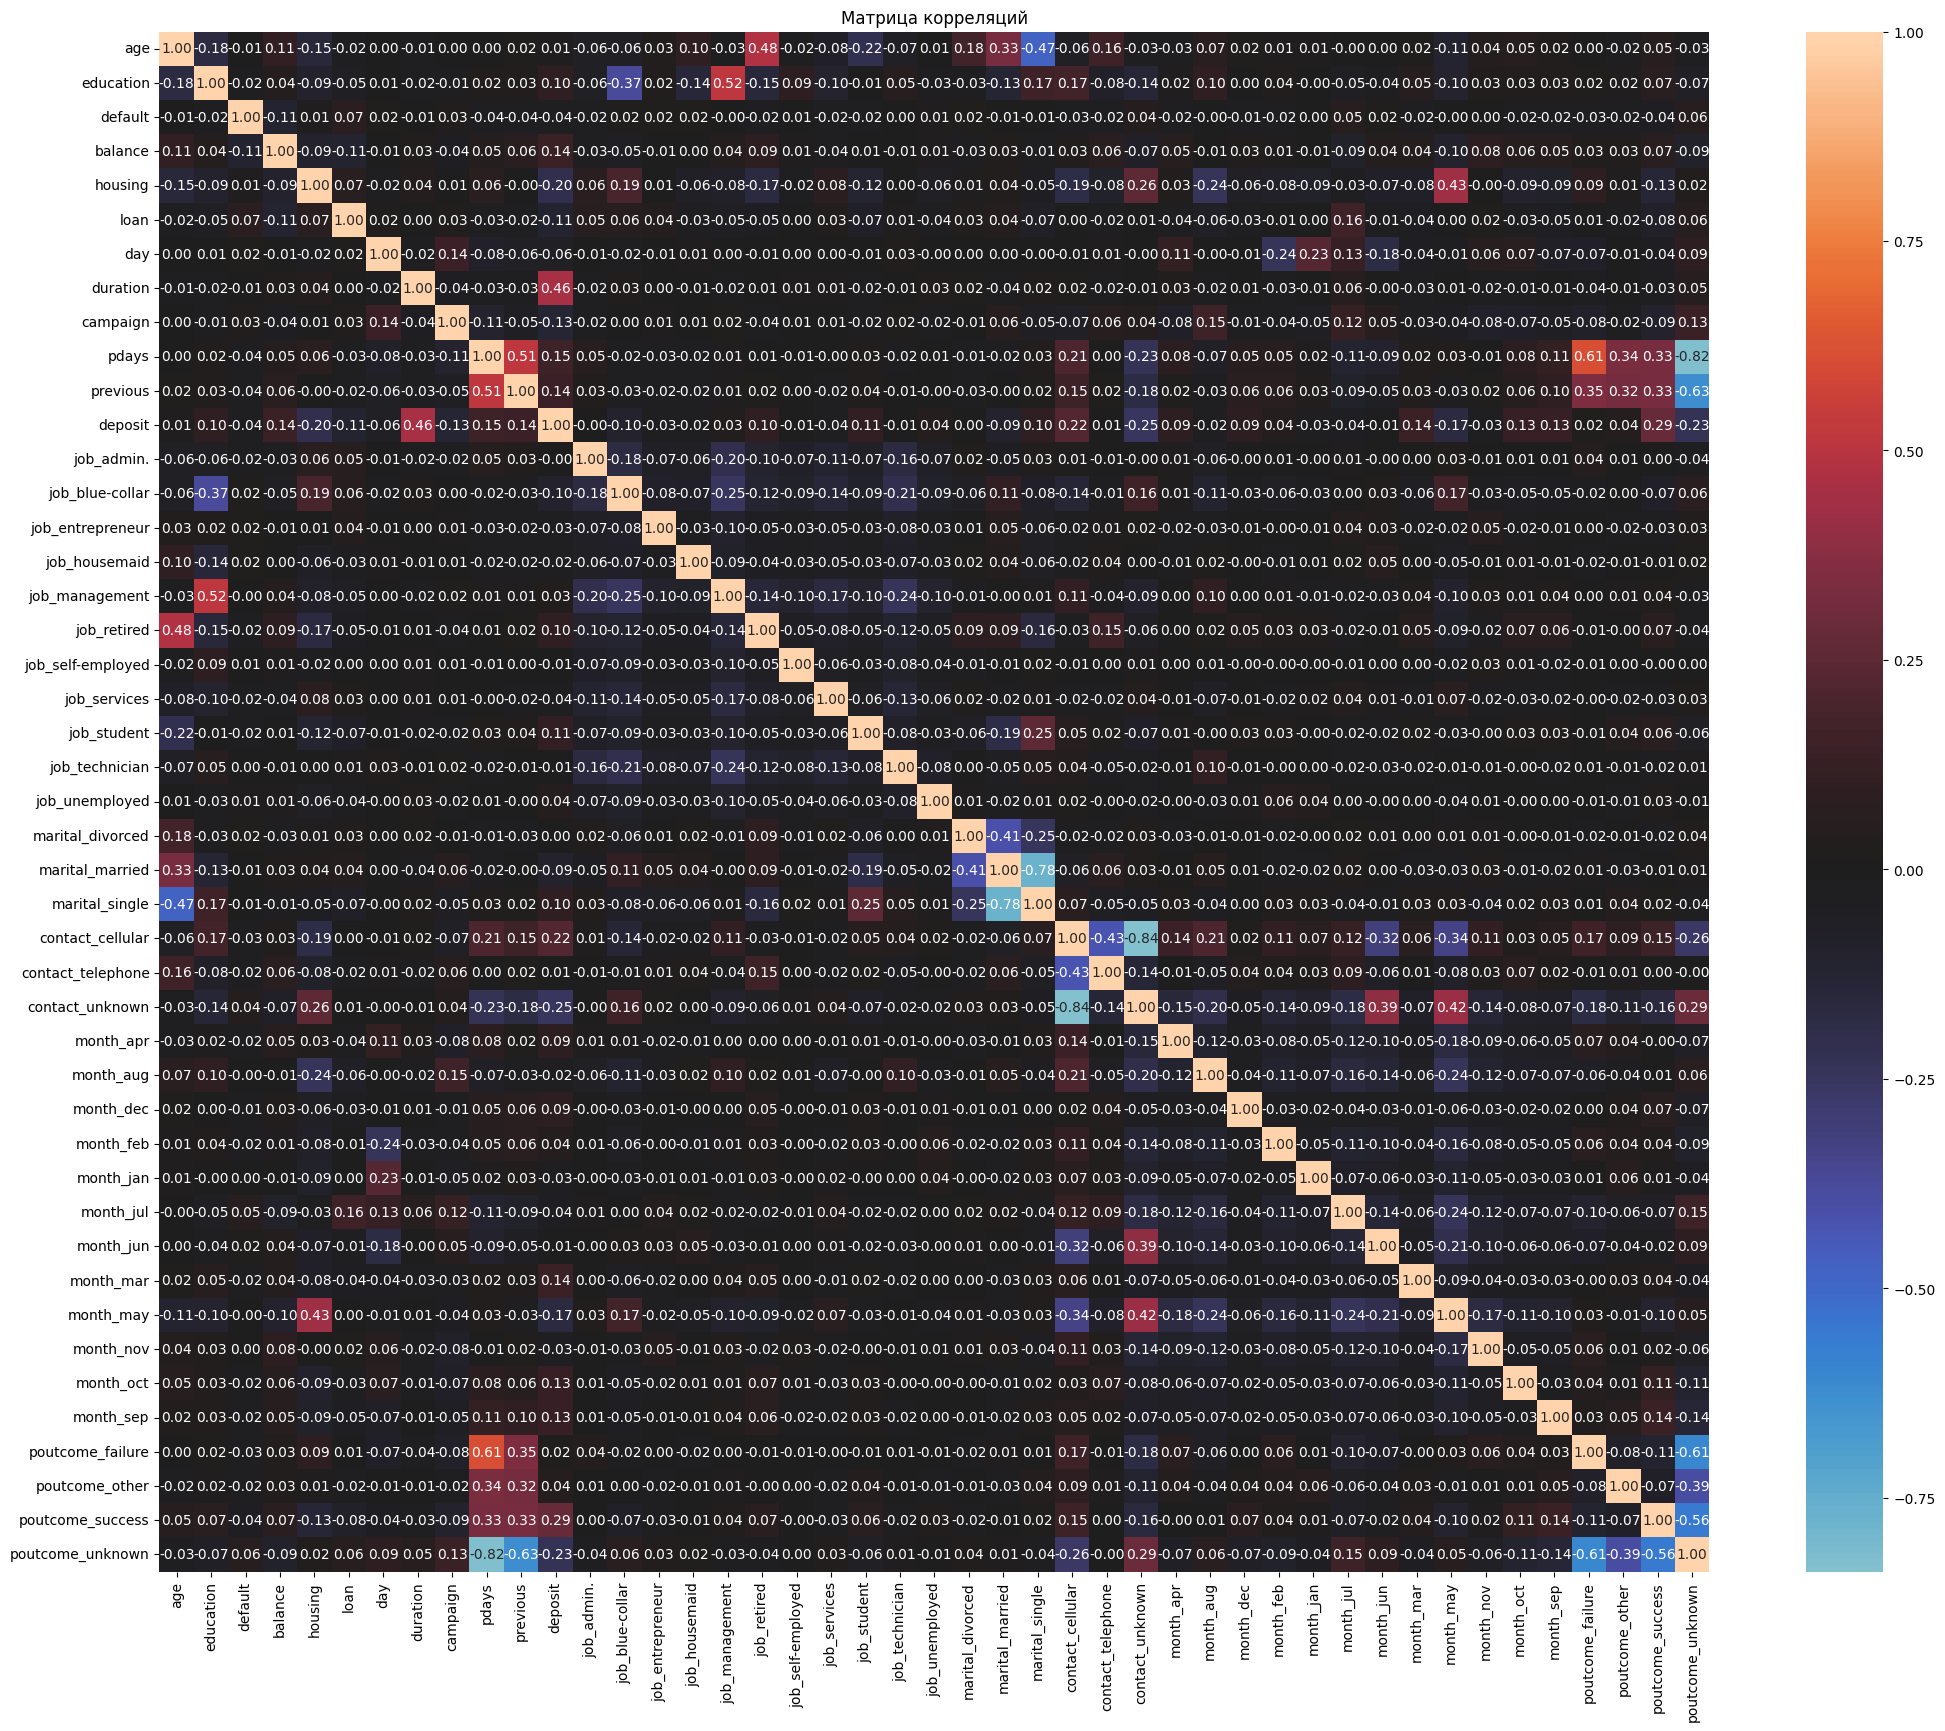

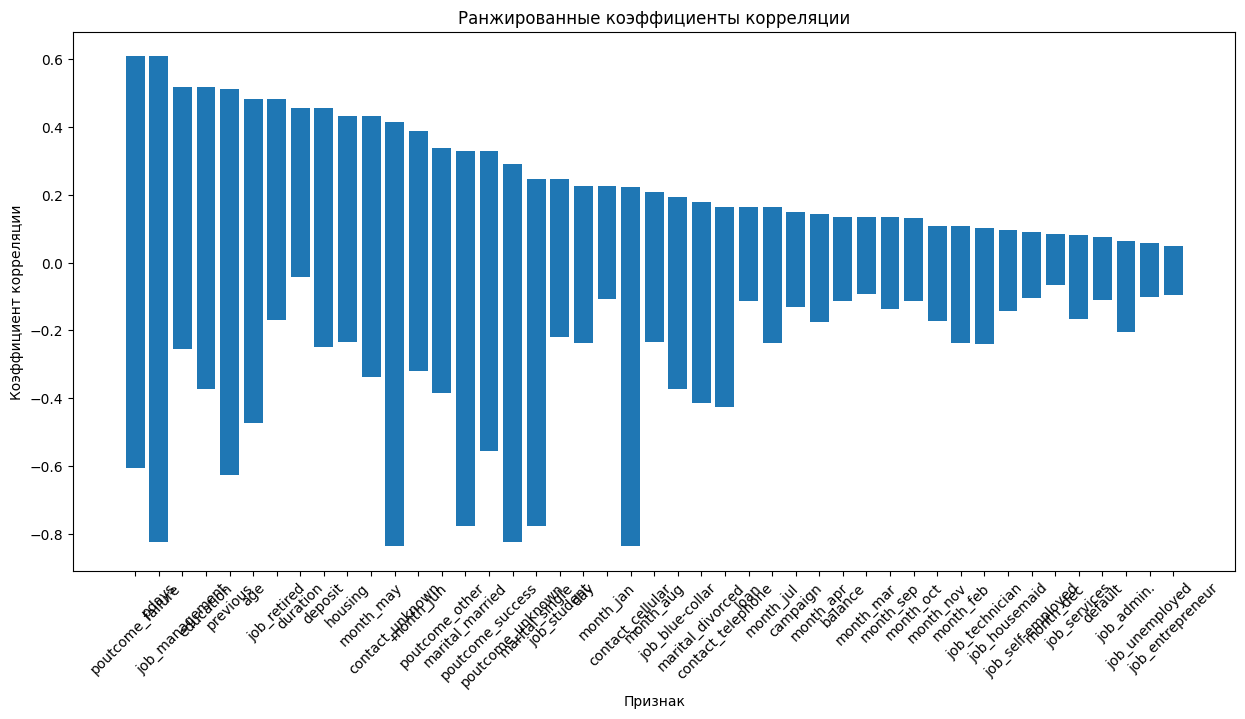

In [55]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Вычисляем матрицу корреляций
correlation_matrix = df_filtered.corr()

# Строим тепловую карту
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, fmt='.2f', annot=True, center=0)
plt.title("Матрица корреляций")
plt.show()

# Строим столбчатую диаграмму для ранжированных коэффициентов корреляции
correlation_df = correlation_matrix.unstack().reset_index(name="correlation")
correlation_df = correlation_df[correlation_df["level_0"] != correlation_df["level_1"]]
correlation_df = correlation_df.sort_values("correlation", ascending=False)

plt.figure(figsize=(15, 7))
plt.bar(correlation_df["level_1"], correlation_df["correlation"])
plt.title("Ранжированные коэффициенты корреляции")
plt.xlabel("Признак")
plt.ylabel("Коэффициент корреляции")
plt.xticks(rotation=45)
plt.show()

### Задания 7 и 8

In [42]:
X = df_filtered.drop(['deposit'], axis=1)
y = df_filtered['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [56]:
y_test

3333     1
6048     0
5675     0
2564     1
8983     0
        ..
1730     1
9672     0
8584     0
10972    0
3818     1
Name: deposit, Length: 3335, dtype: int64

In [58]:
# рассчитайте необходимые показатели
# среднее значение целевой переменной на тестовой выборке
mean_y_test = round(y_test.mean(), 2)

# Выводим результат
print(f"Среднее целевой переменной на тестовой выборке: {mean_y_test}")


Среднее целевой переменной на тестовой выборке: 0.46


### Задание 9

In [60]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

# Отбор 15 лучших признаков с помощью SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

# Получение индексов отобранных признаков
selected_features_indices = selector.get_support(indices=True)

# Извлечение имен отобранных признаков
selected_features = X_train.columns[selected_features_indices]

# Вывод результата
print("Отобранные 15 лучших признаков:")
print(selected_features)

Отобранные 15 лучших признаков:
Index(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### Задание 10

In [62]:
# нормализуйте данные с помощью minmaxsxaler
# Производим нормализацию данных с помощью min-max нормализации
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

# Преобразование в DataFrame для удобства
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features)

# Вывод результата
print("Нормализованные данные:")
print(X_train_scaled.head())
print(X_test_scaled.head())

Нормализованные данные:
    balance  housing  loan  duration  campaign     pdays  previous  \
0  0.426374      1.0   0.0  0.131735   0.00000  0.000000  0.000000   
1  0.346531      0.0   1.0  0.075793   0.00000  0.240936  0.034483   
2  0.335242      1.0   0.0  0.102346   0.02381  0.419883  0.086207   
3  0.407886      0.0   0.0  0.034803   0.00000  0.120468  0.086207   
4  0.571499      0.0   0.0  0.025264   0.00000  0.138012  0.137931   

   contact_cellular  contact_unknown  month_mar  month_may  month_oct  \
0               1.0              0.0        0.0        0.0        0.0   
1               1.0              0.0        0.0        0.0        0.0   
2               0.0              0.0        0.0        1.0        0.0   
3               1.0              0.0        0.0        0.0        0.0   
4               1.0              0.0        0.0        0.0        0.0   

   month_sep  poutcome_success  poutcome_unknown  
0        0.0               0.0               1.0  
1        0.0  

In [63]:
# Рассчитываем среднее арифметическое для первого предиктора
average_first_predictor = round(X_test_scaled[selected_features[0]].mean(), 2)

print(f"Среднее арифметическое для первого предиктора: {average_first_predictor}")

Среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [65]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Обучение модели логистической регрессии
#Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
model.fit(X_train_scaled, y_train)

# Делаем предсказания для тренировочной и тестовой выборок
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



In [66]:
from sklearn.metrics import accuracy_score

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_scaled)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
accuracy = round(accuracy, 2)  # Округление до двух знаков после точки-разделителя

print(f"Точность модели на тестовой выборке: {accuracy}")

Точность модели на тестовой выборке: 0.8


### Задания 2,3,4

In [67]:
# обучите решающие деревья, настройте максимальную глубину

# Обучение модели решающего дерева
#Создаём объект класса DecisionTreeClassifier
model_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений
model_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [70]:
# Делаем предсказания для тренировочной и тестовой выборок
y_train_pred_clf = model_clf.predict(X_train_scaled)
y_test_pred_clf = model_clf.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_clf))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_clf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



In [71]:
# Перебор максимальных глубин деревьев
best_depth = 1
best_accuracy = 0
for depth in range(1, 20):  # Пробуем глубины от 1 до 19
#Создаём объект класса DecisionTreeClassifier
    model_clf_2 = tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=depth,
        random_state=42 #генератор случайных чисел
)
    #Обучаем дерево решений
    model_clf_2.fit(X_train_scaled, y_train)
    
    # Оценка качества на обучающей выборке
    train_accuracy = accuracy_score(y_train, model_clf_2.predict(X_train_scaled))
    
    # Оценка качества на тестовой выборке
    test_accuracy = accuracy_score(y_test, model_clf_2.predict(X_test_scaled))

    print(f"Глубина: {depth}, Точность на обучении: {train_accuracy:.2f}, Точность на тесте: {test_accuracy:.2f}")

    # Обновление лучшей глубины и точности, если наблюдается улучшение качества
    if test_accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = test_accuracy

print(f"Лучшая глубина: {best_depth}, Лучшая точность: {best_accuracy:.2f}")

Глубина: 1, Точность на обучении: 0.71, Точность на тесте: 0.71
Глубина: 2, Точность на обучении: 0.73, Точность на тесте: 0.72
Глубина: 3, Точность на обучении: 0.78, Точность на тесте: 0.77
Глубина: 4, Точность на обучении: 0.78, Точность на тесте: 0.77
Глубина: 5, Точность на обучении: 0.80, Точность на тесте: 0.79
Глубина: 6, Точность на обучении: 0.82, Точность на тесте: 0.80
Глубина: 7, Точность на обучении: 0.82, Точность на тесте: 0.80
Глубина: 8, Точность на обучении: 0.83, Точность на тесте: 0.80
Глубина: 9, Точность на обучении: 0.84, Точность на тесте: 0.80
Глубина: 10, Точность на обучении: 0.85, Точность на тесте: 0.80
Глубина: 11, Точность на обучении: 0.87, Точность на тесте: 0.80
Глубина: 12, Точность на обучении: 0.88, Точность на тесте: 0.80
Глубина: 13, Точность на обучении: 0.89, Точность на тесте: 0.80
Глубина: 14, Точность на обучении: 0.90, Точность на тесте: 0.79
Глубина: 15, Точность на обучении: 0.91, Точность на тесте: 0.78
Глубина: 16, Точность на обучении:

### Задание 5

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [76]:
# подберите оптимальные параметры с помощью gridsearch
# Определение параметров для GridSearchCV
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создание модели решающего дерева
model_gs = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
    )

# Создание объекта GridSearchCV
grid_search = GridSearchCV(model_gs, param_grid=param_grid, cv=5, scoring='accuracy')

# Обучение модели с GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Вывод лучших параметров
print(f"Лучшие параметры: {grid_search.best_params_}")

# Вывод лучшей точности
print(f"Лучшая точность: {grid_search.best_score_:.2f}")

# Обучение модели с лучшими параметрами
best_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                      max_depth=grid_search.best_params_['max_depth'], 
                                      min_samples_split=grid_search.best_params_['min_samples_split'], 
                                      random_state=42)
best_model.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке с лучшей моделью
y_pred = best_model.predict(X_test_scaled)

# Оценка качества лучшей модели
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Точность на тестовой выборке: {test_accuracy:.2f}")

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
Лучшая точность: 0.80
Точность на тестовой выборке: 0.80


In [79]:
# Делаем предсказания для тренировочной и тестовой выборок
y_train_pred_best = best_model.predict(X_train_scaled)
y_test_pred_best = best_model.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_best))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_best))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3634
           1       0.82      0.78      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.80      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [80]:
from sklearn.ensemble import RandomForestClassifier

# обучите на ваших данных случайный лес
# Создаем модель случайного леса с заданными параметрами
random_forest = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

random_forest.fit(X_train_scaled, y_train)

# Делаем предсказания для тренировочной и тестовой выборок
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_test_pred_rf = random_forest.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred_rf))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [92]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# модель градиентного бустинга
model_gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

# Обучите модель на тренировочных данных
model_gb.fit(X_train_scaled, y_train)

# прогнозы на тестовом наборе
y_test_gb = model_gb.predict(X_test_scaled)
# прогнозы на тренировочных данных
y_train_gb = model_gb.predict(X_train_scaled)
# точность модели
accuracy = accuracy_score(y_test, y_test_gb)

# Выведите результаты
print("Точность модели градиентного бустинга:", accuracy)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_gb))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_gb))

Точность модели градиентного бустинга: 0.8239880059970015
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', LogisticRegression(
        solver='sag', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    )),
    ('dt',  DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42 #генератор случайных чисел
    )),
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator = LogisticRegression(
        solver='sag', #алгоритм оптимизации
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [93]:
# прогнозы на тестовом наборе
y_test_reg = reg.predict(X_test_scaled)
# прогнозы на тренировочных данных
y_train_reg = reg.predict(X_train_scaled)
# точность модели
accuracy = accuracy_score(y_test, y_test_reg)

# Выведите результаты
print("Точность модели градиентного бустинга:", accuracy)

#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_reg))
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_reg))

Точность модели градиентного бустинга: 0.8227886056971514
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3634
           1       0.84      0.85      0.84      3136

    accuracy                           0.86      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.86      0.86      0.86      6770

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1790
           1       0.81      0.80      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

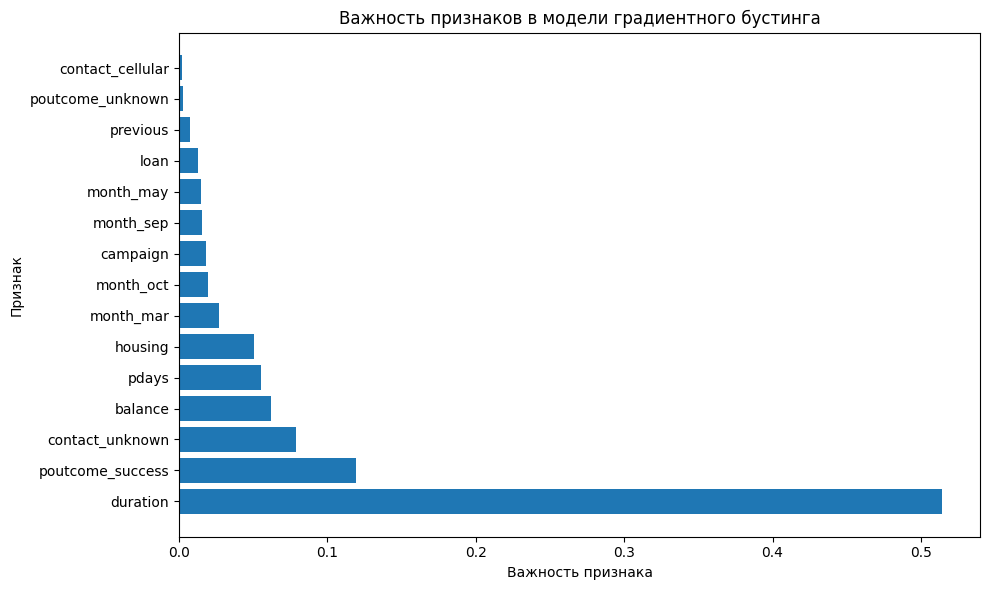

In [111]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Получение важности признаков
feature_importances = model_gb.feature_importances_

# Создание DataFrame для удобства просмотра
feature_importances_df = pd.DataFrame({
    'Признак': X_train_scaled.columns,  # Используйте имена столбцов из данных
    'Важность': feature_importances
}).sort_values(by='Важность', ascending=False)

# Построение графика
plt.figure(figsize=(10, 6))  # Устанавливаем размер графика
plt.barh(feature_importances_df['Признак'], feature_importances_df['Важность'])
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title("Важность признаков в модели градиентного бустинга")
plt.tight_layout()
plt.show()

### Задания 6,7,8

In [95]:
def rf_optuna_optimizer(trial:optuna.trial.Trial):
    """Функция целевой оптимизации для Optuna."""
    
    # Гиперпараметры случайного леса
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    model = ensemble.RandomForestClassifier(
        random_state=42,
        n_estimators=n_estimators,
        max_depth = max_depth,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    
    score = metrics.f1_score(y_train, y_train_pred)
    return score


study = optuna.create_study(study_name='RF', direction='maximize')
study.optimize(rf_optuna_optimizer, n_trials=50)

rf_2 = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
rf_2.fit(X_train_scaled, y_train)
y_test_pred = rf_2.predict(X_test_scaled)
print(f'Test f1-score: {metrics.f1_score(y_test, y_test_pred):.2f}')
print(f'Test accuracy: {metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2024-09-22 21:54:44,090] A new study created in memory with name: RF
[I 2024-09-22 21:54:45,920] Trial 0 finished with value: 0.8464536243180046 and parameters: {'n_estimators': 193, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8464536243180046.
[I 2024-09-22 21:54:47,768] Trial 1 finished with value: 0.8487956487956487 and parameters: {'n_estimators': 176, 'max_depth': 15, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8487956487956487.
[I 2024-09-22 21:54:49,637] Trial 2 finished with value: 0.864881693648817 and parameters: {'n_estimators': 174, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.864881693648817.
[I 2024-09-22 21:54:50,992] Trial 3 finished with value: 0.8515345069325441 and parameters: {'n_estimators': 141, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.864881693648817.
[I 2024-09-22 21:54:52,901] Trial 4 finished with value: 0.8609725685785536 and parameters: {'n_estimators': 175, 'max_

Test f1-score: 0.81
Test accuracy: 0.82
